In [1]:
import pickle
import os
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import collections

import calendar

from pandas.io import gbq
from datetime import datetime
from google.cloud import bigquery
from google.oauth2 import service_account

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
% config InlineBackend . figure_format = 'svg'

/Users/songlin/anaconda2/envs/Python36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
## Set up bigquery environment
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/songlin/CS 224W/project/Github224W-c6c2551f3816.json"
project_id = 'github224w'
client = bigquery.Client(project=project_id)
dataset_id = 'gh_data'
dataset_ref = client.dataset(dataset_id)
dataset = client.get_dataset(dataset_ref)

In [3]:
with open("/Users/songlin/CS 224W/project/gmap_api.pickle", 'rb') as picklefile:
    gmap_api=pickle.load(picklefile)

## Check if commit authors are on Github

In [ ]:
# How many commits are made by committers different from authors
query_job = client.query("""
#standardSQL
SELECT
  project_id AS project,
  COUNT(*) AS commit_count,
  SUM(IF(author_id!=committer_id, 1, 0)) AS commit_not_author
FROM
  `ghtorrent-bq.ght_2018_04_01.commits`
WHERE
  created_at > TIMESTAMP('2016-01-01 00:00:00')
  AND project_id IN (
  SELECT
    *
  FROM
    `github224w.gh_data.python_project_view`)
GROUP BY
  project_id
  """)
results = query_job.result()
p_author_committer = results.to_dataframe()

In [ ]:
# How many authors are fake users?
query_job = client.query("""
#standardSQL
SELECT
  author_id,
  project_id,
  commit_times,
  fake
FROM (
  SELECT
    author_id,
    project_id,
    COUNT(*) AS commit_times
  FROM
    `ghtorrent-bq.ght_2018_04_01.commits`
  WHERE
    created_at > TIMESTAMP('2016-01-01 00:00:00')
  GROUP BY
    author_id,
    project_id) AS a
LEFT JOIN
  `ghtorrent-bq.ght_2018_04_01.users` u
ON
  a.author_id = u.id
    """)
results = query_job.result()
check_author = results.to_dataframe()

## Create a view with python project with number of distinct authors in Q1 2016

In [105]:
view_ref = dataset_ref.table('project_author_commit_2016_q1_view')
view = bigquery.Table(view_ref)

view.view_query = """
#standardSQL
SELECT
  pm.project_id,
  c.author_id,
  COUNT(*) AS commit_times
FROM
  `ghtorrent-bq.ght_2017_01_19.project_commits` pm
LEFT JOIN
  `ghtorrent-bq.ght_2017_01_19.commits` c
ON
  pm.commit_id = c.id
WHERE
  c.created_at >= TIMESTAMP('2016-01-01 00:00:00')
  AND c.created_at < TIMESTAMP('2016-04-01 00:00:00')
  AND pm.project_id IN (
  SELECT
    *
  FROM
    `github224w.gh_data.python_project_view`)
GROUP BY
  pm.project_id,
  c.author_id
"""

view = client.create_table(view)

In [106]:
view_ref = dataset_ref.table('project_author_commit_2016_q2_view')
view = bigquery.Table(view_ref)

view.view_query = """
#standardSQL
SELECT
  pm.project_id,
  c.author_id,
  COUNT(*) AS commit_times
FROM
  `ghtorrent-bq.ght_2017_01_19.project_commits` pm
LEFT JOIN
  `ghtorrent-bq.ght_2017_01_19.commits` c
ON
  pm.commit_id = c.id
WHERE
  c.created_at >= TIMESTAMP('2016-04-01 00:00:00')
  AND c.created_at < TIMESTAMP('2016-07-01 00:00:00')
  AND pm.project_id IN (
  SELECT
    *
  FROM
    `github224w.gh_data.python_project_view`)
GROUP BY
  pm.project_id,
  c.author_id
"""

view = client.create_table(view)

## Check commit distribution for projects in 1st quarter of 2016

### View creation - only need to run once

view_ref = dataset_ref.table('python_project_view')
view = bigquery.Table(view_ref)

view.view_query = """
#standardSQL
SELECT
DISTINCT project_id
FROM
`ghtorrent-bq.ght_2018_04_01.project_languages`
WHERE
LANGUAGE = 'python'
"""
view = client.create_table(view)


In [100]:
## Retrieve Python project and committer information in 1st quarter of 2016
view_ref = dataset_ref.table('project_author_commit_2016_q1_view')
view = bigquery.Table(view_ref)

view.view_query = """
#standardSQL
SELECT
  pm.project_id,
  c.author_id,
  COUNT(*) AS commit_times
FROM
  `ghtorrent-bq.ght_2017_01_19.project_commits` pm
LEFT JOIN
  `ghtorrent-bq.ght_2017_01_19.commits` c
ON
  pm.commit_id = c.id
WHERE
  c.created_at >= TIMESTAMP('2016-01-01 00:00:00')
  AND c.created_at < TIMESTAMP('2016-04-01 00:00:00')
  AND pm.project_id IN (
  SELECT
    *
  FROM
    `github224w.gh_data.python_project_view`)
GROUP BY
  pm.project_id,
  c.author_id
  """

view = client.create_table(view)

In [68]:
project_author_count = py_proj_commits_2016_q1.groupby('project_id')[['author_id']].count()
project_author_value_counts = project_author_count['author_id'].value_counts()

In [27]:
# Store the query result
with open('./data/py_proj_commits_2016_q1.pickle', 'wb') as picklefile:
    pickle.dump(py_proj_commits_2016_q1, picklefile)

In [29]:
# To retrieve the result
with open('./data/py_proj_commits_2016_q1.pickle', 'rb') as picklefile:
    py_proj_commits_2016_q1 = pickle.load(picklefile)

In [30]:
py_proj_commits_2016_q1.sort_values('commit_times', inplace=True)
project_commit_times = py_proj_commits_2016_q1.groupby('project_id')[['commit_times']].sum()
project_commit_value_counts = project_commit_times['commit_times'].value_counts()

In [72]:
project_author_cumsum = np.cumsum(project_commit_value_counts.values)

In [75]:
project_commit_value_counts.values

array([75917, 35174, 23671, ...,     1,     1,     1])

In [78]:
value_sorted = sorted(zip(project_commit_value_counts.index, project_commit_value_counts.values), key = lambda x:x[0])

In [87]:
author_count = [x[0] for x in value_sorted]
project_count = [x[1] for x in value_sorted]
cumsum = np.cumsum(project_count)/sum(project_count)

Text(0.5,1,'Author-project distribution')

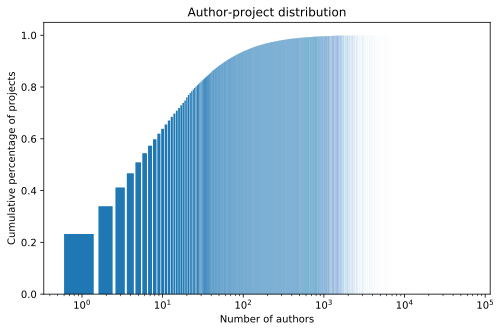

In [98]:
plt.figure(dpi=200, figsize=(8,5))
plt.bar(author_count, cumsum)
plt.xlabel('Number of authors')
plt.xscale('log')
plt.ylabel('Cumulative percentage of projects')
plt.title('Author-project distribution')

Text(0.5,1,'Author-project distribution')

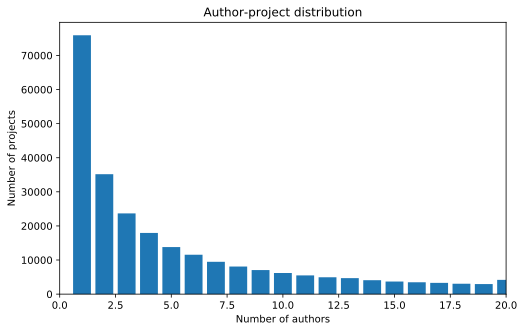

In [93]:
plt.figure(dpi=200, figsize=(8,5))
plt.bar(author_count, project_count)
plt.xlim(0,20)
plt.xlabel('Number of authors')
plt.ylabel('Number of projects')
plt.title('Author-project distribution')

Text(0.5,1,'Project commit distribution')

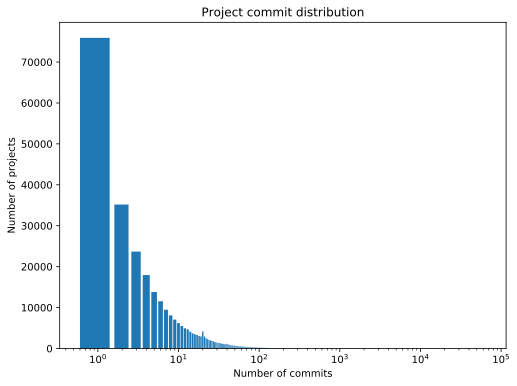

In [32]:
plt.figure(dpi=200, figsize=(8,6))
plt.bar(project_commit_value_counts.index, project_commit_value_counts.values)
plt.xlabel('Number of commits')
plt.ylabel('Number of projects')
plt.xscale('log')
plt.title('Project commit distribution');

In [36]:
## Check commit distribution for projects in 1st quarter of 2016
developer_commit_times = py_proj_commits_2016_q1.groupby('committer_id')[['commit_times']].sum()
developer_commit_value_counts = developer_commit_times['commit_times'].value_counts()

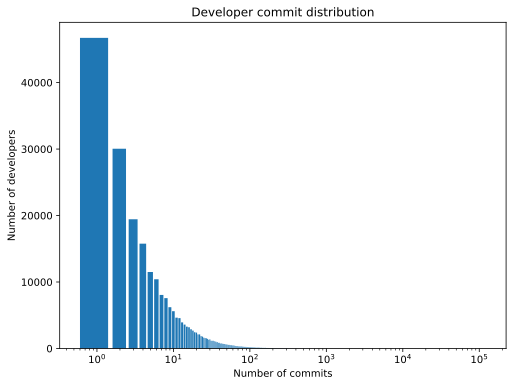

In [37]:
plt.figure(dpi=200, figsize=(8,6))
plt.bar(developer_commit_value_counts.index, developer_commit_value_counts.values)
plt.xlabel('Number of commits')
plt.ylabel('Number of developers')
plt.xscale('log')
plt.title('Developer commit distribution');

In [62]:
project_id = set(project_commit_times[project_commit_times['commit_times']>=10].index)
project_developer_pair = py_proj_commits_2016_q1[py_proj_commits_2016_q1['project_id'].isin(project_id)]

print (f'Projects with more or equal to 10 commits: {project_commit_value_counts[project_commit_value_counts.index>=10].sum()}')
print (f'Number of developers working on projects is {project_developer_pair.shape[0]}')
print (f"NUmber of individual developer regardless of projects is {len(project_developer_pair['committer_id'].unique())}")

Projects with more or equal to 10 commits: 124331
Number of developers working on projects is 631785
NUmber of individual developer regardless of projects is 166877


## Create a view for project commit times (All Times)

In [ ]:
view_ref = dataset_ref.table('project_commit_times_view')
view = bigquery.Table(view_ref)

view.view_query = """
#standardSQL
SELECT
  project_id,
  COUNT(commit_id) AS commit_times
FROM
  `ghtorrent-bq:ght_2018_04_01.project_commits`
GROUP BY
  project_id
"""
view = client.create_table(view)

In [14]:
## Retrieve data from the view
query_job = client.query("""
SELECT
  commit_times,
  COUNT(project_id) AS project_counts
FROM
  `github224w.gh_data.project_commit_times_view`
GROUP BY
  commit_times
    """)

results = query_job.result()
project_commit_counts = results.to_dataframe()

In [17]:
project_commit_counts.sort_values(by='commit_times', inplace=True)

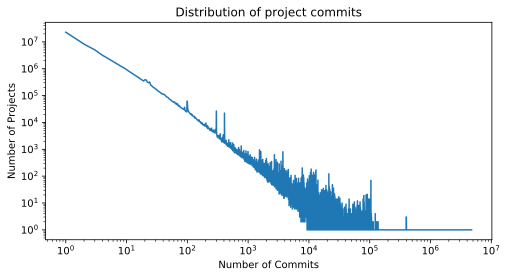

In [29]:
plt.figure(dpi=200, figsize=(8,4))
plt.plot(project_commit_counts['commit_times'], project_commit_counts['project_counts'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Commits')
plt.ylabel('Number of Projects')
plt.title('Distribution of project commits');

In [30]:
project_commit_counts['perc']=project_commit_counts['project_counts']*1.0/sum(project_commit_counts['project_counts'])
project_commit_counts['cum_sum'] = project_commit_counts['perc'].cumsum()

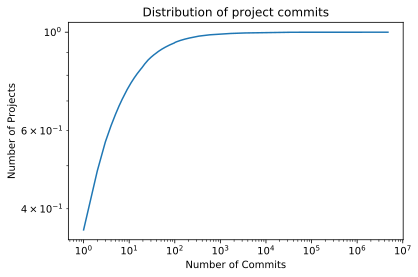

In [37]:
plt.plot(project_commit_counts['commit_times'], project_commit_counts['cum_sum'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Commits')
plt.ylabel('Accumulative percentage of perojects')
plt.title('Accumulated percentage of project based on commits');

## Create a view for project commit times (Since 2016)

In [40]:
view_ref = dataset_ref.table('project_commit_times_since_2016_view')
view = bigquery.Table(view_ref)
view.view_query = """
#standardsql
SELECT
  project_id,
  SUM(IF( created_at>TIMESTAMP('2016-01-01 00:00:00'),
      1,
      0 )) AS commit_since_2016
FROM
  `ghtorrent-bq.ght_2018_04_01.commits`
GROUP BY
  project_id
"""
view = client.create_table(view)

In [43]:
## Retrieve data from the view
query_job = client.query("""
SELECT
  commit_since_2016,
  COUNT(project_id) AS project_counts
FROM
  `github224w.gh_data.project_commit_times_since_2016_view`
GROUP BY
  commit_since_2016
    """)

results = query_job.result()
project_commit_counts_2016 = results.to_dataframe()

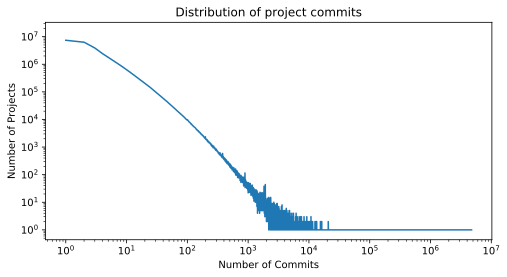

In [46]:
project_commit_counts_2016.sort_values(by='commit_since_2016', inplace=True)
plt.figure(dpi=200, figsize=(8,4))
plt.plot(project_commit_counts_2016['commit_since_2016'], project_commit_counts_2016['project_counts'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Commits')
plt.ylabel('Number of Projects')
plt.title('Distribution of project commits');

In [47]:
project_commit_counts_2016['perc']=project_commit_counts_2016['project_counts']*1.0/sum(project_commit_counts_2016['project_counts'])
project_commit_counts_2016['cum_sum'] = project_commit_counts_2016['perc'].cumsum()

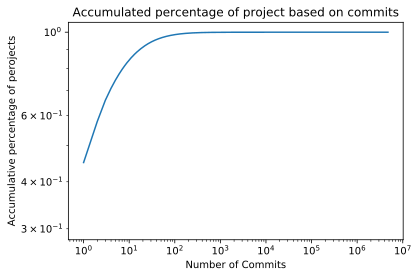

In [51]:
plt.plot(project_commit_counts_2016['commit_since_2016'], project_commit_counts_2016['cum_sum'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Commits')
plt.ylabel('Accumulative percentage of perojects')
plt.title('Accumulated percentage of project based on commits');

## Check the projects with more than 100 commits since 2016 and associated with tag 'Python'

In [62]:
view_ref = dataset_ref.table('python_project_more_than_100_commits')
view = bigquery.Table(view_ref)
view.view_query = """
#standardsql
SELECT
  project_id
FROM
  `github224w.gh_data.project_commit_times_since_2016_view`
WHERE
  commit_since_2016 > 100
  AND project_id IN (
  SELECT
    DISTINCT project_id
  FROM
    `ghtorrent-bq.ght_2017_04_01.project_languages`
  WHERE
    LANGUAGE = 'python')
"""
view = client.create_table(view)

In [63]:
## Retrieve data from the view
query_job = client.query("""
SELECT
  project_id
FROM
  `github224w.gh_data.python_project_more_than_100_commits`
    """)

results = query_job.result()
python_projects = results.to_dataframe()

In [67]:
view_ref = dataset_ref.table('python_project_commiters')
view = bigquery.Table(view_ref)
view.view_query = """
#standardSQL
SELECT
  committer_id,
  project_id
FROM
  `ghtorrent-bq.ght_2017_04_01.commits`
WHERE
  created_at > TIMESTAMP('2016-01-01 00:00:00')
  AND project_id IN (
  SELECT
    project_id
  FROM
    `github224w.gh_data.python_project_more_than_100_commits`)
GROUP BY
  committer_id,
  project_id
"""
view = client.create_table(view)

In [68]:
## Retrieve data from the view
query_job = client.query("""
SELECT
  *
FROM
  `github224w.gh_data.python_project_commiters`
    """)

results = query_job.result()
python_commiters = results.to_dataframe()

In [115]:
commiter_counts = pd.DataFrame(python_commiters.groupby('project_id')['committer_id'].count())
commiter_counts.rename(columns={'committer_id':'committer_count'}, inplace=True)
commiter_value_counts = commiter_counts['committer_count'].value_counts()

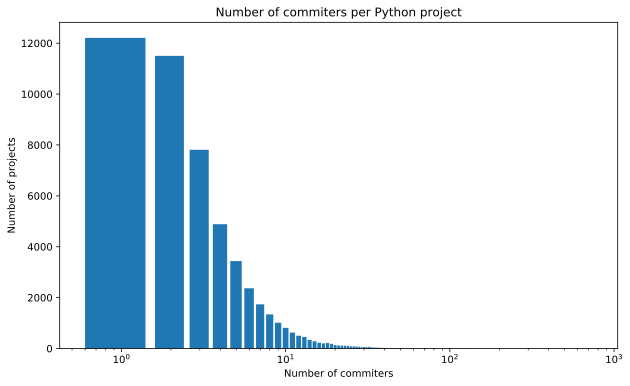

In [132]:
plt.figure(dpi=200, figsize=(10,6))
plt.bar(commiter_value_counts.index, commiter_value_counts.values)
plt.xscale('log')
plt.xlabel('Number of commiters')
plt.ylabel('Number of projects')
plt.title('Number of commiters per Python project');

In [155]:
print (f"Number of python projects with more than 100 commits since 2016: {commiter_counts.shape[0]}")
#print (f"Number of commiters counted by project: {commiter_counts['committer_count'].sum()}")
print (f"Number of unique commiters regardless of project: {len(python_commiters['committer_id'].unique())}")

Number of python projects with more than 100 commits since 2016: 52125
Number of unique commiters regardless of project: 151799


## Retrieve data from table

In [7]:
## Retrieve data from the view
query_job = client.query("""
#standardSQL
SELECT
  project_id,
  author_id,
  commit_times
FROM
  `github224w.gh_data.project_author_commit_2016_q1_view`
WHERE
  project_id IN(
  SELECT
    project_id
  FROM
    `github224w.gh_data.project_g2_author_2016_q1_table`)
""")

results = query_job.result()
q1d = results.to_dataframe()

In [19]:
with open('./data/2016_q1_data.pickle', 'wb') as picklefile:
    pickle.dump(q1d, picklefile, protocol=2)

In [14]:
## Retrieve data from the view
query_job = client.query("""
#standardSQL
SELECT
  project_id,
  author_id,
  commit_times
FROM
  `github224w.gh_data.project_author_commit_2016_q2_view`
WHERE
  project_id IN(
  SELECT
    project_id
  FROM
    `github224w.gh_data.project_g2_author_2016_q2_table`)
""")

results = query_job.result()
q2d = results.to_dataframe()

In [20]:
with open('./data/2016_q2_data.pickle', 'wb') as picklefile:
    pickle.dump(q2d, picklefile, protocol=2)

In [28]:
## Retrieve data from the view
query_job = client.query("""
#standardSQL
SELECT
  project_id,
  author_id,
  commit_times
FROM
  `github224w.gh_data.temp_view2`
WHERE
  project_id IN(
  SELECT
    project_id
  FROM
    `github224w.gh_data.python_project_not_forked_view`)
""")

results = query_job.result()
q1d_original = results.to_dataframe()

In [30]:
with open('./data/2016_q1_original.pickle', 'wb') as picklefile:
    pickle.dump(q1d_original, picklefile, protocol=2)

In [32]:
## Retrieve data from the view
query_job = client.query("""
#standardSQL
SELECT
  project_id,
  author_id,
  commit_times
FROM
  `github224w.gh_data.original_project_2016_q2_view`
WHERE
  project_id IN(
  SELECT
    project_id
  FROM
    `github224w.gh_data.original_project_g3_2016_q2_view`)
""")

results = query_job.result()
q2d_original = results.to_dataframe()

In [34]:
with open('./data/2016_q2_original.pickle', 'wb') as picklefile:
    pickle.dump(q2d_original, picklefile, protocol=2)

In [37]:
author_dict = collections.defaultdict(set)
project_dict = collections.defaultdict(set)
weight_dict = collections.defaultdict(float)
edge_seen = set()

for i in range(q2d_original.shape[0]):
    project_dict[q2d_original.iloc[i,0]].add(q2d_original.iloc[i,1])
    author_dict[q2d_original.iloc[i,1]].add(q2d_original.iloc[i,0])

## Retrive number of commits in March 2016

In [23]:
## Retrieve data from the view
query_job = client.query("""

#standardSQL
SELECT
  author_id,
  SUM(commit_times) AS commit_times
FROM
  `github224w.gh_data.project_author_commit_2016_mar_view`
WHERE
  project_id IN(
  SELECT
    project_id
  FROM
    `github224w.gh_data.project_g2_author_2016_q1_table`)
GROUP BY
  author_id
""")

results = query_job.result()
mar_2016 = results.to_dataframe()

In [71]:
with open('./data/user_mar_2016.pickle', 'wb') as picklefile:
    pickle.dump(mar_2016, picklefile)

## Upload the final report 3053 users to BigQuery

In [12]:
with open('./data/2016_q1_newman-neighbours_kcore.pickle', 'rb') as picklefile:
    finalreport_users = pickle.load(picklefile)

In [13]:
finalreport_users = list(finalreport_users.keys())

In [15]:
users = pd.DataFrame({'user_id':finalreport_users})

In [16]:
users.to_gbq('gh_data.2016_q1_3053_users', 
             project_id,
             chunksize=None,
             if_exists='append',
             verbose=False)

1it [00:05,  5.55s/it]


## Retrieve user details

In [17]:
query_job = client.query("""
#standardSQL
SELECT
  id,
  company,
  created_at,
  long,
  lat,
  country_code
FROM
  `ghtorrent-bq.ght_2017_01_19.users`
WHERE
  id IN (
  SELECT
    *
  FROM
    `github224w.gh_data.2016_q1_3053_users`)
""")

results = query_job.result()
user_details = results.to_dataframe()

In [19]:
user_details['long'] = user_details['long'].apply(lambda x:None if x==0.0 else x)
user_details['lat'] = user_details['lat'].apply(lambda x:None if x==0.0 else x)

In [20]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

In [21]:
user_details['months_since_1970'] = user_details['created_at'].apply(lambda x:diff_month(x, datetime(1970,1,1))) 

In [28]:
user_details.set_index('id', inplace=True)
mar_2016.set_index('author_id', inplace=True)

In [29]:
user_details = user_details.merge(mar_2016, how='left', left_index=True, right_index=True)
user_details.commit_times.fillna(0, inplace=True)
user_details.fillna(value=pd.np.nan, inplace=True)

In [32]:
with open('./data/user_details.pickle', 'wb') as picklefile:
    pickle.dump(user_details, picklefile)